In [5]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import threading
import concurrent.futures
import asyncio

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import requests as req
import base64
import time
import cv2

In [2]:
import import_ipynb
import TeamDetection

importing Jupyter notebook from TeamDetection.ipynb
importing Jupyter notebook from ActionClassificationCosine.ipynb
importing Jupyter notebook from ActionClassificationCosineDatasetGen.ipynb
Loading Poses Data....
Initializing VPTREE....
VPTREE Ready To Use....
importing Jupyter notebook from SinglePlayerPoseDatasetGen.ipynb
importing Jupyter notebook from DrawPose.ipynb


#VP-Tree stuff

In [1]:
def weightedDistanceMatching(poseVector1,poseVector2):
    '''
    
    Parameters
    ----------
    (poseVector1 : a 2D list pose vector of a human + theta [[poseVec],[thetaVector]]
    theta : weigths for human pose vector
    Example theta = [w_0x , w_0y.........w_17x, w_17y])
    or 
    (poseVector1 : a 1D list pose vector of a human, used for building tree. 
    theta : A list with of ones. 
    Example [1,1,.....1] (17x1) )
    
    poseVector2 : pose vector that is to be compared with the human
    
    
    
    Returns
    ------------
    weigtheDistance  : 
    '''
    poseVector1 = np.array(poseVector1) 
    if poseVector1.shape[0] == 36:
        poseVector1 = poseVector1.reshape(1,-1)
        theta = np.ones_like(poseVector1)
    elif poseVector1.shape[0] == 72:
        poseVector1 = poseVector1.reshape(2,36)
        theta = poseVector1[1]
        poseVector1 = poseVector1[0]
    
    poseVector2 = np.array(poseVector2).reshape(1,-1)
    term1 = 1/ np.sum(theta)
    #Finding term 2
    distanceTranspose = np.absolute(poseVector1 - poseVector2).transpose()
    term2 = np.matmul(theta,distanceTranspose)

        
    
    return term1 * term2


#Test

In [6]:
TeamDetection.loadMaskRcnn()
TeamDetection.ActionClassificationCosine.loadPosenetModel()
learner = TeamDetection.getLearner(3)
with open("/Users/sandeep/Desktop/dataandmodles/models/teamDetection/coco.names", 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

[INFO] loading Mask R-CNN from disk...


In [23]:
TeamDetection.ActionClassificationCosine.loadPosenetModel()

In [7]:
frame,h,w = TeamDetection.ActionClassificationCosine.load_image()
frameCopy = frame[:]
frameCopy2 = frame[:]

In [8]:
classIDs,confidences,boxes,masks = TeamDetection.fitMaskRcnn(frame)

In [75]:
playloads = ['']
for detected_object in range(0, len(boxes)):

        left,top,width,height,mask = TeamDetection.getBoxesAndMask(boxes, masks, detected_object)

        bboxFit =  TeamDetection.check_bbox_size(width,height, *frame.shape[0:-1])
        labelFit =  TeamDetection.check_label(classIDs[detected_object])
        
        if bboxFit and labelFit and left>0:
            #uncommet to use basic fast rcnn and remove hsv from teamName
            #team,roi= detectTeam(frameCopy, left ,top, left+width,top+height , algo='basic',mask=mask)
            team,hsv,roi= (TeamDetection.detectTeam(frameCopy, left ,top, left+width,top+height , algo='kmeans',
                                     learner=learner
                                     ,mask=mask))
            
            resizedRoi = TeamDetection.transformRoiBoka(mask,roi,frame,h,w,left,top,left+width,top+height )
            if len(playloads[0]) != 0:
                playloads[0] = playloads[0]+"next"+getImageString(resizedRoi)
            else:
                playloads[0] = getImageString(resizedRoi)

In [85]:
a = playloads[0].split('next')

In [83]:
def convertToBase64(image):
    retval, buffer = cv2.imencode('.jpg', image)
    my_string = base64.b64encode(buffer)
    my_string = my_string.decode('utf-8')
    return my_string
#Sending data to server
def getPoses(playload):
    #image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    url2 = 'http://localhost:3000/postImage'
    data = {'imgBase64':playload}
    r = req.post(url=url2 , data = data)
    poses = r.json()
    
#     url2 = 'http://localhost:3000/getBBox'
#     r = req.post(url=url2)
#     bboxes = r.json()
    return poses
def getImageString(image):
    image_string = convertToBase64(image)
    image_string = 'data:image/png;base64,'+image_string
    return image_string

In [79]:
def process_images(playload):
    start = time.time()
    poses = getPoses(playload)
    end = time.time()
    
    print(f'Total Time Taken:{round(end-start,3)}')
    return poses
    

In [110]:
poses = process_images(playloads[0])

Total Time Taken:1.976


['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']
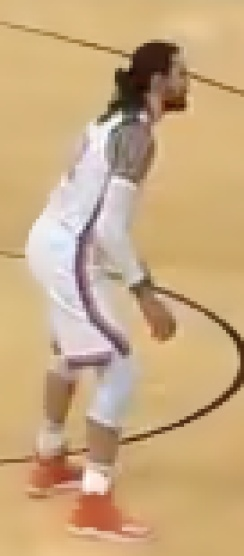
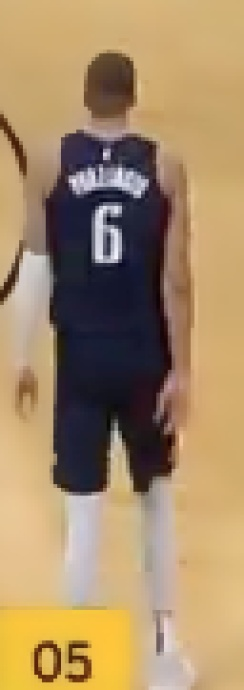
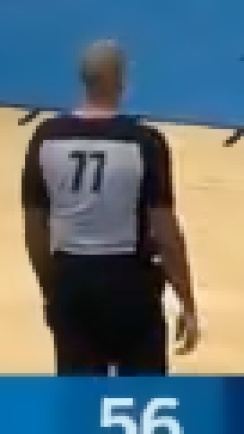
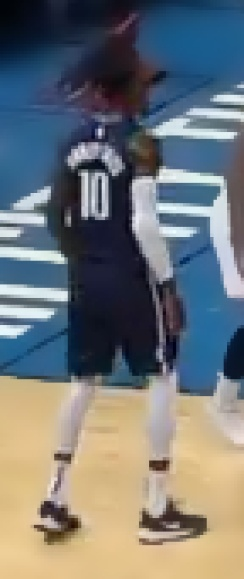
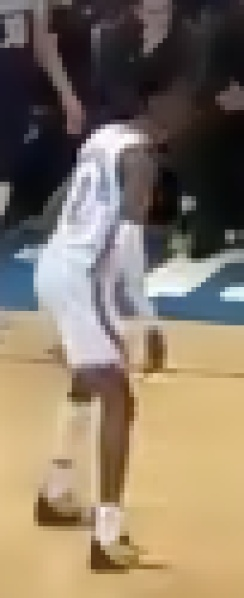
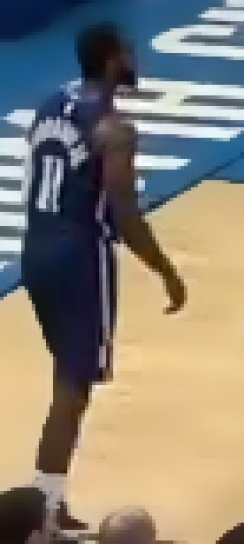
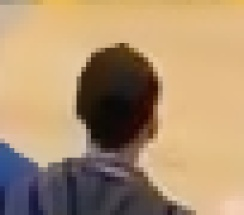
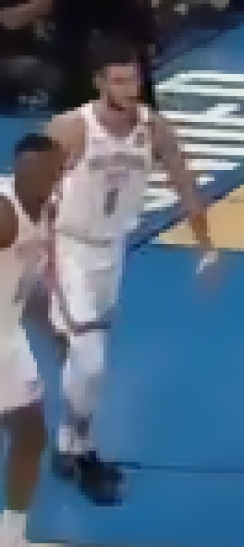
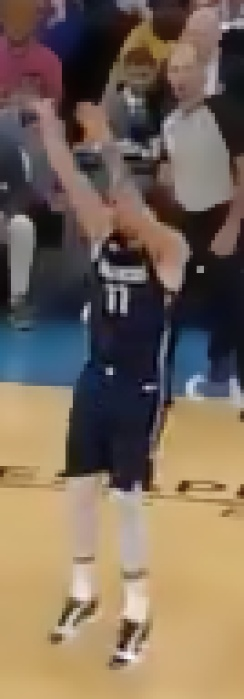
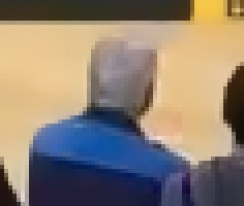
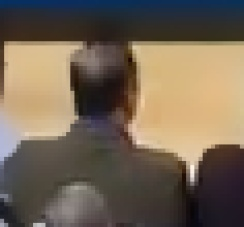
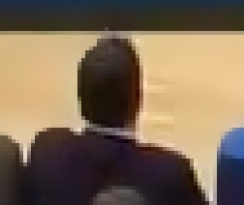
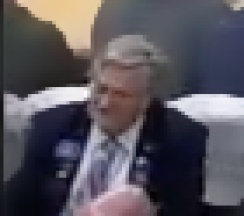

In [101]:
def process_urls(session,playload):
    data = playload['data']
    proc_id = playload['id']
    start = time.time()
    
    url2 = 'http://localhost:3000/postImage'
    with session.post(url=url2 , data = data) as response:
        poses = response.json()
    
    url2 = 'http://localhost:3000/getBBox'
    with session.post(url=url2) as response:
        bboxes = response.json()
    
    
    
    end = time.time()
    print(f'Request ID : {proc_id}, Time:{round(end-start,3)}')
    playloads[proc_id]['poses'] = poses
    playloads[proc_id]['boxes'] = boxes
    #print(f'Finish For proc:{proc_id}')

In [66]:
if __name__ == "__main__":
    start = time.time()
    pool = Pool(processes=1)
    pool.map(process_images, playloads)
    end = time.time()
    print(f'Round 1 total:{round(end-start , 2)}')
    
#     start = time.time()
#     pool.map(process_images, playloads[8:])
#     end  = time.time()
#     print(f'Round 21 total:{round(end-start , 2)}')
    print("[INFO] waiting for processes to finish...")
    pool.close()
    pool.join()
    print("[INFO] multiprocessing complete")

TotalPerPose:0.229
Finish For proc:0
TotalPerPose:0.213
Finish For proc:1
TotalPerPose:0.209
Finish For proc:2
TotalPerPose:0.211
Finish For proc:3
TotalPerPose:0.212
Finish For proc:4
TotalPerPose:0.214
Finish For proc:5
TotalPerPose:0.214
Finish For proc:6
TotalPerPose:0.212
Finish For proc:7
TotalPerPose:0.192
Finish For proc:8
TotalPerPose:0.187
Finish For proc:9
TotalPerPose:0.184
Finish For proc:10
TotalPerPose:0.206
Finish For proc:11
TotalPerPose:0.223
Finish For proc:12
Round 1 total:2.8
[INFO] waiting for processes to finish...
[INFO] multiprocessing complete


In [78]:
playloads = playloads[:8]

#Multi-Threading Approach

In [20]:
async def get_data_asynchronous():
    start = time.time()
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        with req.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [loop.run_in_executor(executor,process_urls,*(session,playload)) for playload in playloads ]
            for response in await asyncio.gather(*tasks):
                pass
    end = time.time()
    print(f'Total Time for all Request : {round(end-start , 2)}')
    

In [21]:
def main():
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(get_data_asynchronous())
    loop.run_until_complete(future)

In [62]:
main()

Request ID : 5, Time:1.753Request ID : 3, Time:1.757
Request ID : 2, Time:1.761Request ID : 4, Time:1.76


Request ID : 7, Time:1.762
Request ID : 1, Time:1.766
Request ID : 0, Time:1.769
Request ID : 6, Time:1.767
Total Time for all Request : 1.77


In [60]:

for playload in playloads:
   i = playload['id']
   image_string = convertToBase64(playload['data'])
   playloads[i]['data'] =  {'imgBase64':'data:image/png;base64,'+image_string}

In [61]:
playloads = playloads[0:8]

In [55]:
len(playloads[8:])

5